In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import findspark
from pyspark.sql import SparkSession
import statistics
from sklearn.naive_bayes import GaussianNB

In [3]:
# read data
train = pd.read_csv('train_selected.csv')
test = pd.read_csv('test_selected.csv')

In [4]:
# extract the labels
train_labels = train['label']
test_labels = test['label']

# remove the label column from the data
train.drop('label', axis=1, inplace=True)
test.drop('label', axis=1, inplace=True)

print("Training Size:", train.shape, "Testing Size:", test.shape)
print("Training Labels Size:", train_labels.shape, "Testing Labels Size:", test_labels.shape)

Training Size: (177041, 7) Testing Size: (58329, 7)
Training Labels Size: (177041,) Testing Labels Size: (58329,)


### KNN Without MapReduce

In [5]:
# KNN implementation without map reduce

# Satndardize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# create a KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# training
knn.fit(train_scaled, train_labels)

# prediction
predicted = knn.predict(test_scaled)

Accuracy of KNN without MapReduce: 0.999879991085052
Classification Report of KNN without MapReduce:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24959
           1       1.00      1.00      1.00     33370

    accuracy                           1.00     58329
   macro avg       1.00      1.00      1.00     58329
weighted avg       1.00      1.00      1.00     58329



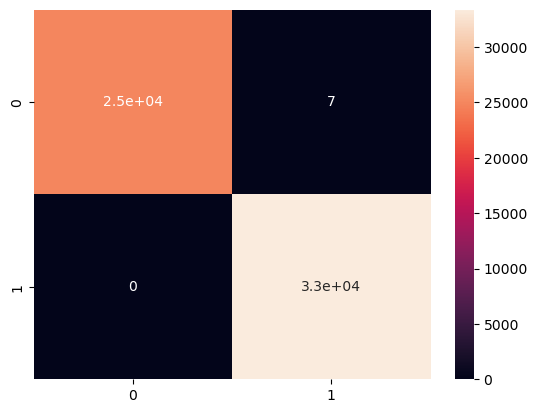

In [6]:
# Evaluation of knn without mapreduce
accuracy_without_map_reduce = accuracy_score(test_labels, predicted)
conf_matrix = confusion_matrix(test_labels, predicted)
class_report = classification_report(test_labels, predicted)

print("Accuracy of KNN without MapReduce:", accuracy_without_map_reduce)
sns.heatmap(conf_matrix, annot=True)
print("Classification Report of KNN without MapReduce:\n", class_report)

### KNN using MapReduce

In [24]:
# create a pyspark session
findspark.init() # initialize the path to the spark directory
spark=SparkSession.builder.master("local[*]").appName("KNN").getOrCreate() # creates or gets (if already created) a spark session
sc=spark.sparkContext # creates a spark context

In [25]:
# Read the data using pyspark
training_data = spark.read.csv('train_selected.csv', header=True, inferSchema=True).rdd
testing_data = spark.read.csv('test_selected.csv', header=True, inferSchema=True).rdd

# map the training and test data to features and labels => x[0] is the class label and x[1] is the features
train_data = training_data.map(lambda x: (x[-1], x[:-1]))
test_data = testing_data.map(lambda x: (x[-1], x[:-1]))

#### MapReduce
➢First, the training data will be divided into multiple splits.

➢The map phase will determine the k-nearest neighbors in the different
splits of the data.

➢As a result of each map, the k nearest neighbors together with their
computed distance values will be emitted to the reduce phase.

➢Afterwards, the reduce phase will compute the definitive neighbors
from the list obtained in the map phase.

➢The reduce phase will determine which are the final k nearest neighbors
from the list provided by the maps.

➢This parallel implementation provides the exact classification rate as the
original k-NN model.

In [ ]:
def predict_knn(train_data, test_row):
    # separate the label and the features
    features = test_row[1]
    label = test_row[0]

    # map the training data with the test row
    distances = train_data.map(lambda x: (x[0], np.linalg.norm(np.array(x[1]) - np.array(features))))

    # sort the distances
    sorted_distances = distances.sortBy(lambda x: x[1])

    # get the k nearest neighbors
    k_nearest = sorted_distances.take(5)

    # get the labels of the k nearest neighbors
    k_nearest_labels = [x[0] for x in k_nearest]

    # get the most common label
    predicted_label = statistics.mode(k_nearest_labels)

    print("Actual Label:", label, "Predicted Label:", predicted_label)

    return (label, predicted_label)


predicted_labels = [predict_knn(train_data, test_row) for test_row in test_data.collect()]

# separate the actual and predicted labels
labels, predicted_labels = zip(*predicted_labels)

In [ ]:
# Evaluation
accuracy_without_map_reduce = accuracy_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)
class_report = classification_report(test_labels, predicted_labels)

print("Accuracy of Naive Bayes with MapReduce:", accuracy_without_map_reduce)
sns.heatmap(conf_matrix, annot=True)
print("Classification Report of KNN without MapReduce:\n", class_report)

spark.stop()

First failed attempt: KNN with PySpark
1. Pyspark doesn't work well with clustering techniques
2. Using mapreduce consumes much more time than sklearn knn classifier
3. The accuracy and f1 score for the built-in knn are 99.8 and 1 respectively
4. Approximate calculations:
    - While printing a single label is classified in 12.5s.
    - The test data is 58329 rows
    - So it would take approximately 200 hours to classify the whole dataset
    - Built-in KNN approximatly takes 10s to classify the whole test set with an accuracy of 99.9

#### Naive Bayes Without MapReduce

In [7]:
# create another spark session for naive bayes 
gnb = GaussianNB()

# train the model
model = gnb.fit(train, train_labels)

# predict the test set
predicted_labels = model.predict(test)

Accuracy of Naive Bayes without MapReduce: 0.9998457028236384
Classification Report of KNN without MapReduce:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24959
           1       1.00      1.00      1.00     33370

    accuracy                           1.00     58329
   macro avg       1.00      1.00      1.00     58329
weighted avg       1.00      1.00      1.00     58329



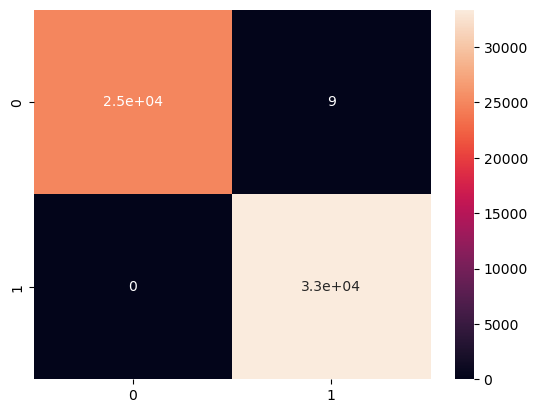

In [8]:
# Evaluation of Naive Bayes without MapReduce
accuracy_without_map_reduce = accuracy_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)
class_report = classification_report(test_labels, predicted_labels)

print("Accuracy of Naive Bayes without MapReduce:", accuracy_without_map_reduce)
sns.heatmap(conf_matrix, annot=True)
print("Classification Report of KNN without MapReduce:\n", class_report)

#### Naive Bayes Using MapReduce:

Naive Bayes Algorithm:

➢The first requirement is to collect the probabilities of all class labels, P(ci).

➢The second thing the naïve Bayes classifier needs to know is the
conditional probabilities of each attribute aj given each class label ci,
namely P (aj |ci). For each attribute and its possible values, computing
the conditional probabilities given each class label is required.

➢After that, the naïve Bayes classifier can be tested over the testing set.

➢For each record in the testing set, the naïve Bayes classifier assigns the
classifier label ci

In [9]:
# create a new spark session for naive bayes
# create a pyspark session
findspark.init() # initialize the path to the spark directory
spark = SparkSession.builder.master("local[*]").appName("NaiveBayes").getOrCreate() # creates or gets (if already created) a spark session
spark_context = spark.sparkContext # creates a spark context

In [10]:
# read the training data and create an rdd
training_data = spark.read.csv('train_selected.csv', header=True, inferSchema=True).rdd

# calculate the number of features in the dataset => number of columns - labels column
number_of_features = len(training_data.first()) - 1

# separate the training data into the features and the labels
# each row in the rdd will be a tuple of (features, class_label) => (x[0], x[1])
training_data = training_data.map(lambda x: (x[:-1], int(x[-1])))


################ 1. Calculate Class Priors ################

# calculate count of samples classified as an certain class for each class
class_counts = training_data.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y)

# calculate the total number of samples
total_samples = training_data.count()

# calculate class priors
class_priors = class_counts.map(lambda x: (x[0], x[1] / float(total_samples))) # should be 2 records (0, class_prior_of_0) & (1, class_prio_of_1)

# convert thr class priors to a dictionary
class_priors_dictionary = class_priors.collectAsMap()

# create a dictionary for class counts for easier access
class_counts_dictionary = dict(class_counts.collect())

################ 2. Calculate Conditional Probabilities for Each Feature/Class ################
# The conditional probabilities are calculated as follows:
# For each feature we calculate the conditional probability for all its values for each class
 

# calculate the counts of each feature for each class
# this step is to calculate the count of each feature classified as a certain class 
# where i is the index of the feature, x[0][i] is the value of the feature, and x[1] is the class
# the output of the flatMap is a list of tuples for each record in the training data
feature_counts_per_class = training_data.flatMap(lambda x: [(i, x[0][i], x[1]) for i in range(len(x[0]))])

# calculate the count of each feature for each class
# the output of the map will be a tuple of the feature index, the feature value, and the class and 1
# reduce by key will sum the counts of the features for each class
feature_counts_per_class = feature_counts_per_class.map(lambda x: ((x[0], x[1], x[2]), 1)).reduceByKey(lambda x, y: x + y)

# output some of the feature counts
# print(feature_counts_per_class.take(5))

# sort the feature counts by the feature index and then by the class x = ((feature_index, feature_value, class), count)
feature_counts_per_class = feature_counts_per_class.sortBy(lambda x: (x[0][0], x[0][2]))

# Calculate the conditional probabilities for each feature/class
# the consitional probability is the count of the feature classified as a certain class divided by the count of the class
# class_counts_dictionary[x[0][2]] is the count of the class {0: count_of_0, 1: count_of_1} => dictionary[class]
# here the x = ((feature_index, feature_value, class), count)
# the output will be = ((feature_index, feature_value, class), (count ,conditional_probability)) for the feature 
conditional_prbabilties = feature_counts_per_class.map(lambda x: ((x[0][0], x[0][1], x[0][2]), (x[1], class_counts_dictionary[x[0][2]])))

# sort the conditional probabilities by the feature index and then by the class
conditional_prbabilties = conditional_prbabilties.sortBy(lambda x: (x[0][0], x[0][2]))

# mapValues function maps the values without changing the keys => each record will have the same key and the function is executed on the values only
# x[0] is the count of the feature classified as a certain class and x[1] is the count of the class
# add 1 to the numerator and the number of features to the denominator to avoid zero probabilities
conditional_prbabilties = conditional_prbabilties.mapValues(lambda x: (x[0] + 1) / (x[1] + number_of_features))

# sort the conditional probabilities by the feature index and then by the class
conditional_prbabilties = conditional_prbabilties.sortBy(lambda x: (x[0][0], x[0][2]))

# create a dictionary for the conditional probabilities for easier access
conditional_prbabilties_dictionary = conditional_prbabilties.collectAsMap()

# convert the dict to have the class as the key
conditional_prbabilties_dictionary = conditional_prbabilties.map(lambda x: (x[0][2], ((x[0][0], x[0][1]), x[1]))).groupByKey().mapValues(list).collectAsMap()

In [11]:
# create a dictionary for the conditional probabilities for easier access
# the format of the final dictionary should be {class: {feature_index: [(feature_value, conditional_probability)]}}
# so for each feature index, we have a list of tuples of the feature value and the conditional probability
# for example if the feature is bianry (has only 2 values) the list will have 2 tuples
final_conditional_probabilities = {}

# iterate over the conditional probabilities dictionary
# the key is the class and the value is a list of tuples of the feature index, the feature value, and the conditional probability
for class_key, values in conditional_prbabilties_dictionary.items():
    # create a dictionary for each class in the final dictionary
    final_conditional_probabilities[class_key] = {}

    # iterate over the list of tuples (feature index, feature value, conditional probability)
    for value in values:
        # the key of the inner dictionary is the feature index 
        feature_index = value[0][0]
        feature_value = (value[0][1], value[1]) # value[0][1] is the feature value and value[1] is the conditional probability for the feature value of the index for the given class

        # add the feature value and the conditional probability to the inner dictionary => check if the feature index exists in the inner dictionary
        # final_conditional_probabilities[class_key][feature_index] = [feature_value] if feature_index not in final_conditional_probabilities[class_key] else final_conditional_probabilities[class_key][feature_index].append(feature_value)
        if feature_index in final_conditional_probabilities[class_key]:
            final_conditional_probabilities[class_key][feature_index].append(feature_value)
        else:
            final_conditional_probabilities[class_key][feature_index] = [feature_value]


In [12]:
# create the map function for the prediction phase
def predict(test_row):

    # seperate the features and the labels
    features = test_row[:-1]
    label = test_row[-1]

    predicted_label = None

    max_posterior_probability = float('-inf')

    # calculate the posterior probability for each class and assign the maximum probability to the predicted label
    for class_label in class_priors_dictionary.keys(): # either 0 or 1
        posterior_probability = class_priors_dictionary[class_label] # initialize the posterior probability with the class prior probability
        
        # iterate over the features 
        # but we need the index of the feature to access the conditional probability for the feature value
        for feature_index, feature_value in enumerate(features):
            # get the conditional probability for the feature value and class label
            for value, final_conditional_probability in final_conditional_probabilities[class_label][feature_index]:

                if value == feature_value:
                    posterior_probability *= final_conditional_probability
                    break
        
        # prediction of the label based on the highest posterior probability
        if posterior_probability > max_posterior_probability:
            max_posterior_probability = posterior_probability
            predicted_label = class_label

    return (label, predicted_label)


In [13]:
# Actual prediction of the test set
testing_data = spark.read.csv('test_selected.csv', header=True, inferSchema=True).rdd

# predict the test set one row at a time
predictions = testing_data.map(predict)

# convert to list
predictions = predictions.collect()

# split the predictions into the actual and the predicted labels
test_labels, predicted_labels = zip(*predictions)

Accuracy of Naive Bayes with MapReduce: 0.9200226302525331
Classification Report of KNN without MapReduce:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90     24959
           1       0.88      0.99      0.93     33370

    accuracy                           0.92     58329
   macro avg       0.93      0.91      0.92     58329
weighted avg       0.93      0.92      0.92     58329



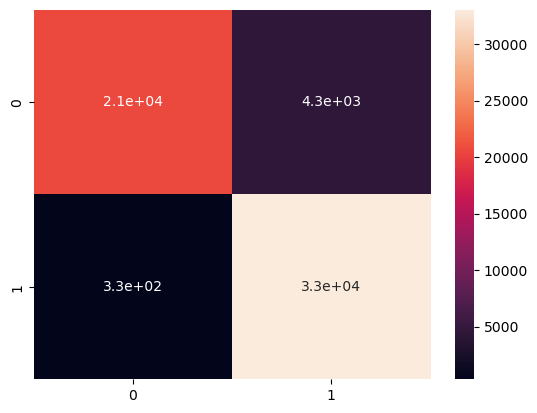

In [14]:
# Evaluation of Naive Bayes with MapReduce
accuracy_without_map_reduce = accuracy_score(test_labels, predicted_labels)
conf_matrix = confusion_matrix(test_labels, predicted_labels)
class_report = classification_report(test_labels, predicted_labels)

print("Accuracy of Naive Bayes with MapReduce:", accuracy_without_map_reduce)
sns.heatmap(conf_matrix, annot=True)
print("Classification Report of KNN without MapReduce:\n", class_report)

spark.stop()